In [1]:
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, AutoTokenizer
import torch
import numpy as np

from scipy.spatial import distance


In [2]:
# Load the pre-trained GPT-2 model
model = GPT2LMHeadModel.from_pretrained("openai-community/gpt2")
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")

/opt/anaconda3/envs/gpt2_env/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:

def create_onehot_vector(n, index):
    # Create a zero vector of dimension n
    onehot_vector = torch.zeros(n)
    
    # Set the element at the specified index to 1
    onehot_vector[index] = 1
    
    return onehot_vector

In [118]:
input_text = hamlet_str
input_ids = tokenizer.encode(input_text, return_tensors='pt')

In [146]:
outputs = model(input_ids, labels=input_ids, output_attentions=True)

In [131]:
attentions = outputs.attentions
attentions[0].shape

torch.Size([1, 12, 48, 48])

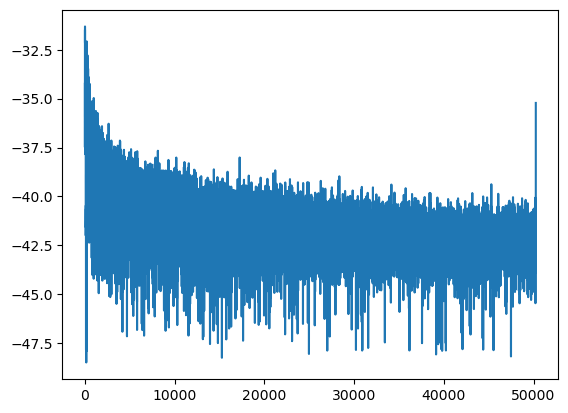

In [115]:
plt.plot(logits[0,0].detach().numpy())

In [5]:
with torch.no_grad():
    word_embedding = model.base_model.wte(input_ids)

In [134]:
def split_heads(tensor, num_heads, attn_head_size):
    """
    Splits hidden_size dim into attn_head_size and num_heads
    """
    new_shape = tensor.size()[:-1] + (num_heads, attn_head_size)
    tensor = tensor.view(new_shape)
    return tensor.permute(0, 2, 1, 3)  # (batch, head, seq_length, head_features)

In [6]:
# Get the combined weight matrix
combined_weights = model.base_model.h[0].attn.c_attn.weight

# GPT-2 combines Q, K, and V in a single matrix. Let's say the hidden size is 768.
hidden_size = model.config.hidden_size

# Split the combined weight matrix into W_Q, W_K, and W_V
W_Q = combined_weights[:, :hidden_size]
W_K = combined_weights[:, hidden_size:2*hidden_size]
W_V = combined_weights[:, 2*hidden_size:3*hidden_size]

print("W_Q shape:", W_Q.shape)
print("W_K shape:", W_K.shape)
print("W_V shape:", W_V.shape)

W_Q shape: torch.Size([768, 768])
W_K shape: torch.Size([768, 768])
W_V shape: torch.Size([768, 768])


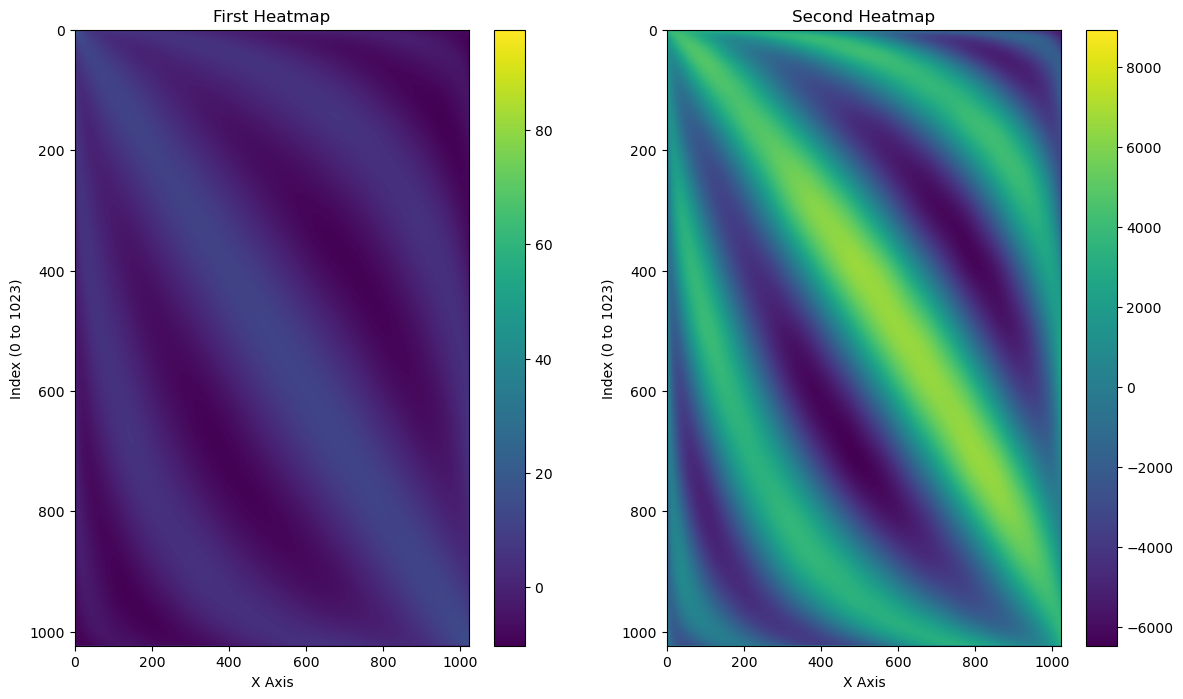

In [7]:
# Assuming 'model', 'W_Q', and 'W_K' are already defined

# Initialize matrices to store the data for all indices
data1_matrix = []
data2_matrix = []

# Loop over all indices from 0 to 1023
for index in range(1024):
    # Data for the first plot
    data1 = model.base_model.wpe.weight.detach().numpy()[index] @ model.base_model.wpe.weight.detach().numpy().T
    data1_matrix.append(data1)
    
    # Data for the second plot
    data2 = (W_Q.T @ model.base_model.wpe.weight[index]).detach().numpy() @ (W_K.T @ model.base_model.wpe.weight.T).detach().numpy()
    data2_matrix.append(data2)

# Convert lists to numpy arrays for plotting
data1_matrix = np.array(data1_matrix)
data2_matrix = np.array(data2_matrix)

# Create two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(14, 8))

# Plotting the first heatmap
cax1 = axs[0].imshow(data1_matrix, aspect='auto', cmap='viridis')
axs[0].set_title('First Heatmap')
axs[0].set_xlabel('X Axis')
axs[0].set_ylabel('Index (0 to 1023)')
fig.colorbar(cax1, ax=axs[0])

# Plotting the second heatmap
cax2 = axs[1].imshow(data2_matrix, aspect='auto', cmap='viridis')
axs[1].set_title('Second Heatmap')
axs[1].set_xlabel('X Axis')
axs[1].set_ylabel('Index (0 to 1023)')
fig.colorbar(cax2, ax=axs[1])

# Show the plots
plt.show()

In [132]:
input_embs = model.base_model.wte.weight.T
Q_embs = W_Q.T @ model.base_model.wte.weight.T
K_embs = W_K.T @ model.base_model.wte.weight.T
V_embs = W_V.T @ model.base_model.wte.weight.T

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

# Assuming 'input_embs' is already defined with shape (768, 50257)

# Compute the cosine similarity matrix between columns
similarity_matrix = cosine_similarity(input_embs[:,::10].detach().numpy().T)



In [11]:
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list

# Perform hierarchical clustering
linked = linkage(1 - similarity_matrix, method='average')

# Determine the order of tokens by the clustering
order = leaves_list(linked)

# Reorder the similarity matrix based on the clustering
reordered_similarity_matrix = similarity_matrix[order, :][:, order]

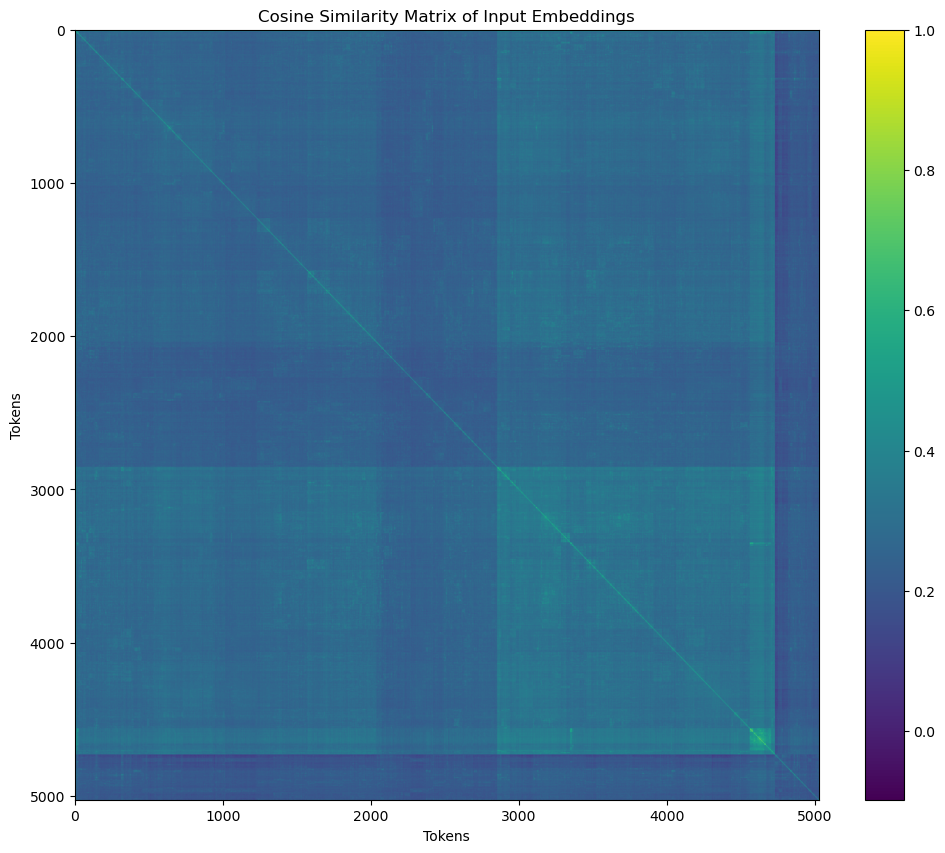

In [13]:
# Plot the similarity matrix using a heatmap
plt.figure(figsize=(12, 10))
plt.imshow(reordered_similarity_matrix, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Cosine Similarity Matrix of Input Embeddings')
plt.xlabel('Tokens')
plt.ylabel('Tokens')
plt.show()

In [9]:
column_norms = torch.norm(input_embs, dim=0, keepdim=True)
column_norms_Q = torch.norm(Q_embs, dim=0, keepdim=True)
column_norms_K = torch.norm(K_embs, dim=0, keepdim=True)
column_norms_V = torch.norm(V_embs, dim=0, keepdim=True)

sorted_norms_Q, sorted_ids_Q = torch.sort(column_norms_Q, descending=True)
sorted_norms_K, sorted_ids_K = torch.sort(column_norms_K, descending=True)
sorted_norms_V, sorted_ids_V = torch.sort(column_norms_V, descending=True)
sorted_norms, sorted_ids = torch.sort(column_norms, descending=True)

In [10]:
print(tokenizer.convert_ids_to_tokens(sorted_ids[0][:100]))
print(tokenizer.convert_ids_to_tokens(sorted_ids_Q[0][:100]))
print(tokenizer.convert_ids_to_tokens(sorted_ids_K[0][:100]))
print(tokenizer.convert_ids_to_tokens(sorted_ids_V[0][:100]))

['SPONSORED', 'ĸļ', 'soDeliveryDate', 'enegger', 'Reviewer', 'yip', 'theless', 'inventoryQuantity', 'interstitial', '76561', 'natureconservancy', 'DragonMagazine', 'ĠFlavoring', 'isSpecialOrderable', 'ngth', '20439', 'lihood', 'xual', 'etheless', 'BuyableInstoreAndOnline', 'Interstitial', 'terday', 'ufact', 'Downloadha', 'ĠCanaver', 'tein', 'sonian', 'ahime', 'è¦ļéĨĴ', 'quickShipAvailable', 'MpServer', 'NetMessage', 'merce', 'wcsstore', 'ãĤ´ãĥ³', 'ĠCosponsors', 'ascript', 'soType', 'hower', 'taboola', 'actionDate', 'catentry', '£ı', 'pmwiki', 'ciating', 'externalActionCode', 'glers', 'uyomi', 'soever', 'selves', 'aukee', 'nces', 'issance', 'ĠILCS', 'ktop', 'ĪĴ', 'enhagen', 'ertodd', 'ulhu', 'ĠLeilan', 'Reloaded', 'ĠguiActiveUnfocused', 'hyde', 'ModLoader', 'etsk', 'cffffcc', 'abouts', 'Ġmathemat', 'SourceFile', 'llah', 'wagen', 'milo', 'ĠlargeDownload', 'vernment', 'rawdownloadcloneembedreportprint', 'ĠGOODMAN', 'thood', 'ibaba', 'ĠSeym', 'phia', 'TPPStreamerBot', 'inav', 'romeda', 'âĹ

In [11]:
rand_token = np.random.randint(0,tokenizer.vocab_size - 1)
hi = tokenizer("vector", return_tensors="pt")['input_ids']
bye = tokenizer("bye", return_tensors="pt")['input_ids']
rand_emb = input_embs.T[rand_token].detach().numpy()
hi_emb = input_embs.T[hi][0,0].detach().numpy()
bye_emb = input_embs.T[bye][0,0].detach().numpy()
hi_emb @ bye_emb, 1 - distance.cosine(hi_emb,bye_emb), hi_emb @ rand_emb, 1 - distance.cosine(hi_emb,rand_emb), bye_emb @ rand_emb, 1 - distance.cosine(bye_emb,rand_emb), tokenizer.convert_ids_to_tokens(rand_token)

(4.6174064,
 0.2406093921185375,
 4.9078608,
 0.3098637631042106,
 5.5966587,
 0.2972064052424972,
 'Luke')

In [12]:
rand_token = np.random.randint(0,tokenizer.vocab_size - 1)
hi = tokenizer("man", return_tensors="pt")['input_ids']
bye = tokenizer(",", return_tensors="pt")['input_ids']
rand_Q_emb = Q_embs.T[rand_token].detach().numpy()
hi_Q_emb = Q_embs.T[hi][0,0].detach().numpy()
bye_Q_emb = Q_embs.T[bye][0,0].detach().numpy()
rand_K_emb = K_embs.T[rand_token].detach().numpy()
hi_K_emb = K_embs.T[hi][0,0].detach().numpy()
bye_K_emb = K_embs.T[bye][0,0].detach().numpy()
rand_V_emb = V_embs.T[rand_token].detach().numpy()
hi_V_emb = V_embs.T[hi][0,0].detach().numpy()
bye_V_emb = V_embs.T[bye][0,0].detach().numpy()
hi_Q_emb @ bye_K_emb, 1 - distance.cosine(hi_Q_emb,bye_K_emb), bye_Q_emb @ hi_K_emb, 1 - distance.cosine(bye_Q_emb,hi_K_emb), hi_Q_emb @ rand_K_emb, 1 - distance.cosine(hi_Q_emb,rand_K_emb), bye_Q_emb @ rand_K_emb, 1 - distance.cosine(bye_Q_emb,rand_K_emb), tokenizer.convert_ids_to_tokens(rand_token)

(66.1257,
 0.07326492502229942,
 82.451996,
 0.11156070157224385,
 -156.4833,
 -0.14643039398101543,
 -74.50069,
 -0.08416632840981508,
 'ocations')

In [255]:
model.base_model.wpe.weight[:hamlet_tokenized.shape[1]].shape

torch.Size([12, 768])

In [256]:
#hamlet_str = "To be, or not to be: that is the question: Whether ’tis nobler in the mind to suffer the slings and arrows of outrageous fortune, or to take arms against a sea of troubles and by opposing end them."
hamlet_str = "The boy bit the apple, the girl bit the orange."
hamlet_tokenized = tokenizer(hamlet_str, return_tensors="pt")['input_ids']
hamlet_tokens = tokenizer.convert_ids_to_tokens(hamlet_tokenized[0])

pos_emb = model.base_model.wpe.weight[:hamlet_tokenized.shape[1]]

hamlet_emb = input_embs.T[hamlet_tokenized[0]] + pos_emb
hamlet_Q_emb = Q_embs.T[hamlet_tokenized[0]] + pos_emb @ W_Q
hamlet_K_emb = K_embs.T[hamlet_tokenized[0]] + pos_emb @ W_K
hamlet_V_emb = V_embs.T[hamlet_tokenized[0]] + pos_emb @ W_V

In [257]:
hamlet_Q_heads.shape

torch.Size([1, 12, 12, 64])

In [258]:
hamlet_Q_heads = split_heads(hamlet_Q_emb.unsqueeze(0), 12, 64)
hamlet_K_heads = split_heads(hamlet_K_emb.unsqueeze(0), 12, 64)
hamlet_V_heads = split_heads(hamlet_V_emb.unsqueeze(0), 12, 64)

In [177]:
flattened_inner_product.shape

torch.Size([1, 12, 2304])

In [259]:
# Step 1: Compute the inner product matrix
inner_product_matrix = hamlet_Q_heads @ torch.transpose(hamlet_K_heads, 2, 3)

In [260]:
# Step 3: Apply softmax to each row
softmax = torch.nn.Softmax(dim=3)
softmax_matrix = softmax(inner_product_matrix)

In [229]:
softmax_matrix.shape

torch.Size([1, 12, 12, 12])

In [67]:
threshold_index = int(0.8 * len(sorted_inner_product))
threshold_value = sorted_inner_product[threshold_index]
threshold_value

131.80107

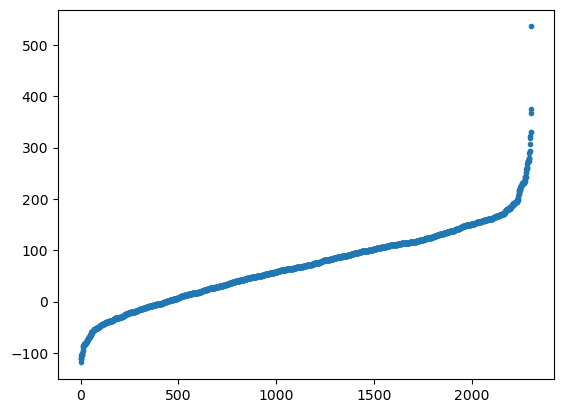

In [71]:
plt.plot(sorted_inner_product,'.')

In [212]:
softmax_matrix[0,0,6,9], hamlet_tokens[]

(tensor(0.7672, grad_fn=<SelectBackward0>), 'Ġis')

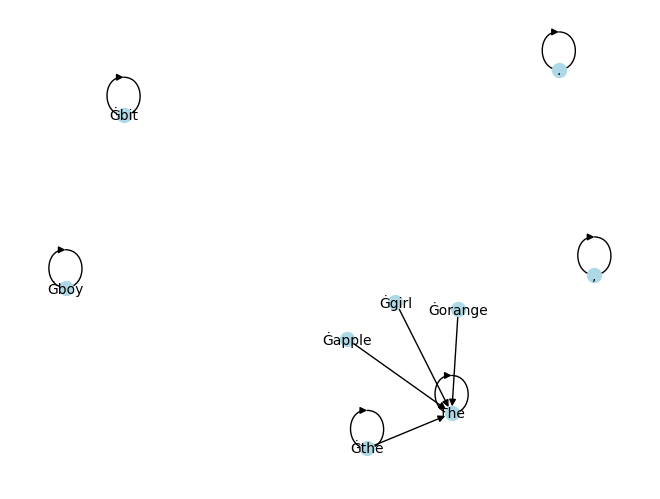

In [277]:
import networkx as nx
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA

adjacency_matrix = (softmax_matrix[0,1] >= 0.01).detach().numpy()

# Step 4: Construct the graph from the adjacency matrix
G = nx.from_numpy_array(adjacency_matrix, create_using=nx.DiGraph)

mapping = dict(zip(G, hamlet_tokens))
G = nx.relabel_nodes(G, mapping)

# Step 3: Add labels to the edges to show the weights
edge_labels = nx.get_edge_attributes(G, 'weight')
rounded_edge_labels = {key: round(value, 1) for key, value in edge_labels.items()}

# Step 4: Visualize the graph (optional)
pos = nx.spring_layout(G, k=0.5)  # Choose a layout
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=100, font_size=10)
#nx.draw_networkx_edge_labels(G, pos, edge_labels=rounded_edge_labels)

plt.show()

# # Step 5: Apply spectral clustering to find clusters
# n_clusters = 5  # Arbitrary number of clusters; this can be tuned based on the dataset
# spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
# cluster_labels = spectral_clustering.fit_predict(adjacency_matrix)

# # Assign clusters to nodes
# clusters = {i: cluster_labels[i] for i in range(len(cluster_labels))}

# # Identify cluster sizes to help choose a cluster for PCA
# cluster_sizes = {i: list(cluster_labels).count(i) for i in range(n_clusters)}

# # Select the largest cluster for PCA
# largest_cluster = max(cluster_sizes, key=cluster_sizes.get)
# indices_for_pca = [i for i, label in clusters.items() if label == largest_cluster]

# # Step 6: Perform PCA on the selected cluster
# pca = PCA(n_components=2)
# selected_data = Q_embs[:, indices_for_pca]  # or K_embs[:, indices_for_pca]
# pca_result = pca.fit_transform(selected_data.T)

# import ace_tools as tools; tools.display_dataframe_to_user(name="PCA Results", dataframe=pca_result)

# pca_result[:5], cluster_sizes 

In [50]:
# Step 3: Visualize the graph (optional)
nx.draw(G, with_labels=True, node_color='lightblue', font_weight='bold', arrows=True)
plt.show()

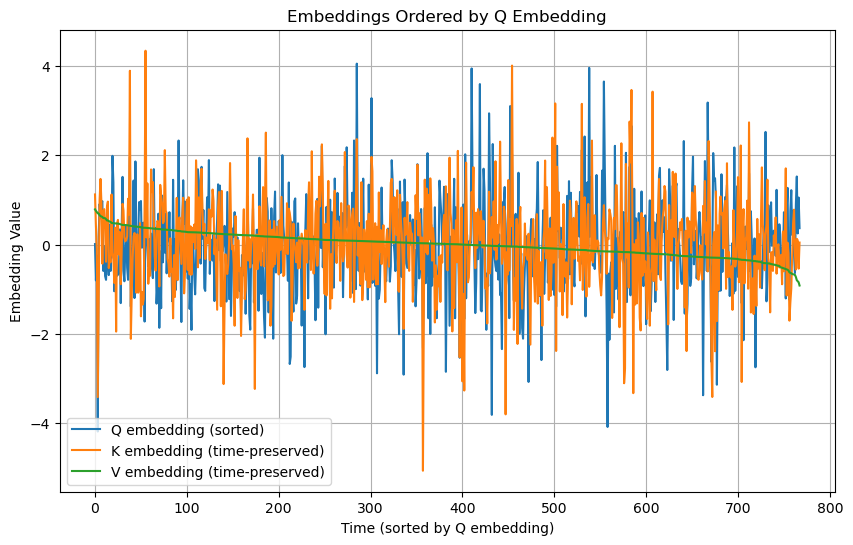

In [74]:
# Assuming hi_Q_emb, hi_K_emb, and hi_V_emb are NumPy arrays
# Step 1: Sort hi_Q_emb and get the sorted indices
sorted_indices = np.argsort(hi_V_emb)[::-1]  # Sort in descending order

# Step 2: Reorder hi_Q_emb, hi_K_emb, and hi_V_emb using the sorted indices
hi_Q_emb_sorted = hi_Q_emb[sorted_indices]
hi_K_emb_sorted = hi_K_emb[sorted_indices]
hi_V_emb_sorted = hi_V_emb[sorted_indices]

# Step 3: Plot the sorted data against "time" (index in this case)
time = range(len(hi_Q_emb_sorted))

plt.figure(figsize=(10, 6))

plt.plot(time, hi_Q_emb_sorted, label='Q embedding (sorted)')
plt.plot(time, hi_K_emb_sorted, label='K embedding (time-preserved)')
plt.plot(time, hi_V_emb_sorted, label='V embedding (time-preserved)')

plt.xlabel('Time (sorted by Q embedding)')
plt.ylabel('Embedding Value')
plt.title('Embeddings Ordered by Q Embedding')
plt.legend()
plt.grid(True)

plt.show()

In [246]:
plt.plot(input_embs.detach().numpy()[:,1000])

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [67]:
norm((W_Q @ W_K.T).detach().numpy(), ord=2)

731.3839

In [62]:
from scipy.linalg import norm
from scipy.stats import ortho_group

W_QVAR = W_Q @ W_Q.T

# Generate a random orthogonal matrix
Q = ortho_group.rvs(dim=W_QVAR.shape[0])

induced_norm = norm(W_QVAR.detach().numpy(), ord=2)
Q_norm = norm(Q @ Q.T, ord=2)
induced_norm, Q_norm

(506.2395, 1.000000000000004)